In [1]:
import h5py
import numpy as np
from numpy import linalg
import os
import matplotlib.pyplot as plt
# import mat73
from collections import namedtuple
from scipy.signal import butter, sosfiltfilt
from scipy.signal import stft
from scipy.signal import ShortTimeFFT
from scipy.signal import butter
from mne.decoding import CSP
from scipy import stats
import mne
from sklearn.covariance import MinCovDet
import pandas as pd

In [2]:
import seaborn as sns
import copy
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import scipy.linalg as la

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [ ]:
filename = r"C:\Users\hodor\Documents\Quasi\QuasiBalls\data - raw\01ES\good_ind.h5"
with h5py.File(filename, 'r') as h5f:
    print(h5f.keys())
    print(h5f['qm_point'][:])

# labels

In [328]:
filename = r'C:\Users\hodor\Documents\Quasi\quasi-clf\data\test_quashariki\01ES\process\dataset.csv'
df = pd.read_csv(filename)
session = 'om_click'
df_ses = df.loc[df.session == session].copy()
df_sel = df_ses.loc[df_ses.action == 'selection'].copy().reset_index()
good_epoch_click = df_sel.loc[(df_sel.label == 'intent') & (df_sel.action == 'selection')].index
session = 'om_point'
df_ses = df.loc[df.session == session].copy()
df_sel = df_ses.loc[df_ses.action == 'selection'].copy().reset_index()
good_epoch_point = df_sel.loc[(df_sel.label == 'intent') & (df_sel.action == 'selection')].index
good_epoch_click.shape, good_epoch_point.shape

((49,), (46,))

In [428]:
filename = r'C:\Users\hodor\Documents\Quasi\quasi-clf\data\test_quashariki\01ES\process\dataset.csv'
df = pd.read_csv(filename)
session = 'qm_point'
df_ses = df.loc[df.session == session].copy()
df_sel = df_ses.loc[df_ses.action == 'selection'].copy().reset_index()
df_sel.shape

(46, 19)

# data

In [4]:
filename = r'C:\Users\hodor\Documents\Quasi\quasi-clf\data\covariance_matrixes\AnatolyExample.h5'
with h5py.File(filename, 'r') as h5f:
    c1 = h5f['overt'][:]
    c2 = h5f['nomove'][:]

In [7]:
def change_trigger(eeg):
    photo_orig = eeg[:, -1]

    photo = np.zeros(len(photo_orig))
    photo[np.where(photo_orig == np.min(photo_orig))] = 1
    photo = photo.astype(int)
    return np.concatenate([eeg[:, :-1], photo.reshape((-1, 1))], axis=1)

def get_eeg(filename):
    with h5py.File(filename) as h5f:
        print(h5f['eeg'].keys())
        # eeg = h5f['eeg/channels'][:]
        eeg = h5f['eeg/data'][:-1]
        return change_trigger(eeg)

def get_cov(filename, cond_name, control_name):
    with h5py.File(filename, 'r') as h5f:
        return h5f[cond_name][:], h5f[control_name][:]

In [8]:
raw_data_folder = r'..\data'
eeg_1 = get_eeg(os.path.join(raw_data_folder, 'mulines_OVERTexample.h5'))
eeg_2 = get_eeg(os.path.join(raw_data_folder, 'mulines_NOMOVexample.h5'))

<KeysViewHDF5 ['blocks', 'data', 'streamInfo']>
<KeysViewHDF5 ['blocks', 'data', 'streamInfo']>


## check filter

In [9]:
def filter(eeg, N=4, lo=8, hi=15, fs=1000):
    # частотный фильтр
    sos = butter(N=N, Wn=(lo, hi), btype='bandpass', output='sos', fs=fs)
    return sosfiltfilt(np.ascontiguousarray(sos), eeg, axis=0)

eeg_f1 = filter(eeg_1 * (10**6))

In [460]:
eeg_f1[:, 0]

array([ 3.01962135e+01,  2.76918189e+01,  2.50534406e+01, ...,
        1.95256569e-03,  6.25056170e-04, -3.83809454e-04])

In [10]:
from scipy.fft import fft, fftfreq

(1.0, 200.0)

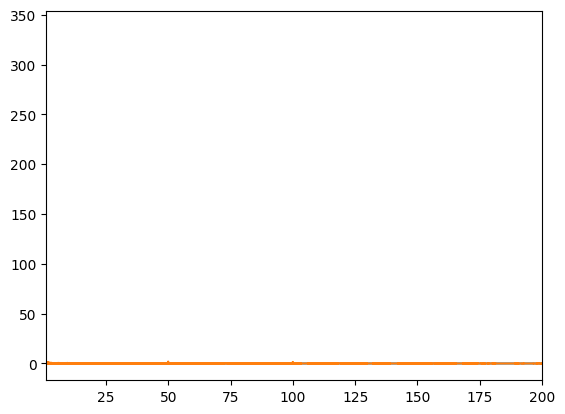

In [11]:
yf = fft(eeg_f1[:, 0])
y = fft(eeg_1[:, 0] * (10**6))
N = len(eeg_f1[:, 0])
xf = fftfreq(N, 1/1000)[:N//2]
plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.plot(xf[1:], 2.0/N * np.abs(y[1:N//2]))
plt.xlim(1, 200)

In [12]:
def get_fft(eeg):
    SFT = ShortTimeFFT(win=np.ones(1000), hop=100, fs=1000,  fft_mode='onesided' )
    fft_res = np.abs(SFT.stft(eeg, axis=0)) ** 2
    fft_t = SFT.t(len(eeg))
    return fft_res, fft_t

fft_res, fft_t = get_fft(eeg_1[:, 0] * (10**6))

In [13]:
fft_res_f, fft_t_f = get_fft(eeg_f1[:, 0])

In [14]:
fft_res.shape

(501, 5063)

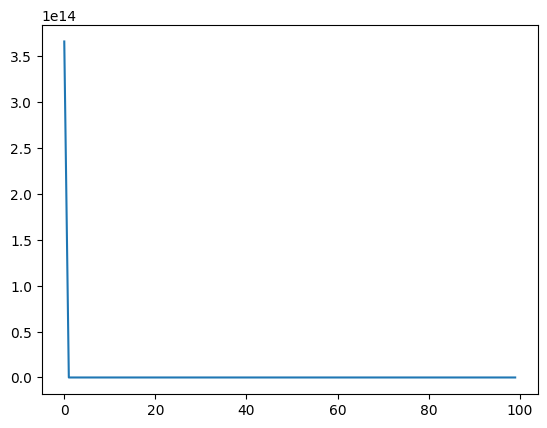

In [15]:
# plt.plot(fft_res_f[:100, 100])
plt.plot(fft_res[:100, 100])

## calculate robust cov

In [24]:
def filter(eeg, N=4, lo=8, hi=15, fs=1000):
    # частотный фильтр
    sos = butter(N=N, Wn=(lo, hi), btype='bandpass', output='sos', fs=fs)
    return sosfiltfilt(np.ascontiguousarray(sos), eeg, axis=0)

def get_epochs(eeg, trigger, epoch_width=3000):
    events_ind = np.where(np.diff(trigger) == 1)[0]
    epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind), 1)) 
    epochs = np.array([eeg[x, :64] for x in epochs_ind])
    return epochs

def calculate_robust_cov(epochs):
    data = np.concatenate(epochs, axis=0)
    MCD = MinCovDet(support_fraction=0.5, store_precision=False)
    cov = MCD.fit(data)
    return cov

eeg_f_1 = filter(eeg_1[:, :64] * (10**6))
eeg_f_2 = filter(eeg_2[:, :64] * (10**6))
epochs_1 = get_epochs(eeg_f_1, eeg_1[:, -1], epoch_width=2000)
epochs_2 = get_epochs(eeg_f_2, eeg_2[:, -1], epoch_width=2000)

In [17]:
epochs_1.shape, epochs_2.shape

((100, 2000, 64), (56, 2000, 64))

In [26]:
cov1 = calculate_robust_cov(epochs_1[:, 250:-250, :])

In [27]:
cov2 = calculate_robust_cov(epochs_2[:, 250:-250, :])

In [29]:
c1 = cov1.covariance_
c2 = cov2.covariance_

In [339]:
filename_output = os.path.join(raw_data_folder, 'covariance.h5')
with h5py.File(filename_output, 'a') as h5f:
    h5f.create_dataset('om_both_clean', data=c1)

## get robust cov

In [396]:
c1, c2 = get_cov(os.path.join(raw_data_folder, 'covariance.h5'), 'om_both_clean', 'nomove')

In [30]:
def csp(c1, c2):
    R1 = c1 / np.trace(c1)
    R2 = c2 / np.trace(c2)
    L, W = la.eig(R1, R1+R2)
    order = np.argsort(L)
    L = L[order]
    W = W[:, order]
    fProj = np.dot(W.T, R1).T
    d, p = fProj.shape
    maxind = np.argmax(np.abs(fProj), axis=0)
    # maxinds = np.array([np.where(np.abs(W[:, i]) == np.max(np.abs(W[:, i])))[0][0] for i in range(W.shape[1])])
    max_magnitudes = np.array([fProj[maxind[i], i] for i in range(W.shape[1])])
    rowsign = np.sign(max_magnitudes)
    W_fixed = W * rowsign
    projForward = la.pinv(W_fixed).T
    evals = L
    return W_fixed, projForward, evals

In [31]:
projInverse, projForward, evals = csp(c1, c2)

## evals

In [32]:
evals = np.abs(evals)

In [33]:
ediff = np.diff(evals)
ok_steps = np.where(ediff > np.median(ediff) * 5)[0]
ok_evalLow_inds = np.arange(np.max(ok_steps[ok_steps < 10]))
ok_evalHigh_inds = np.arange(len(evals)-1, np.min(ok_steps[ok_steps > 30]), -1)

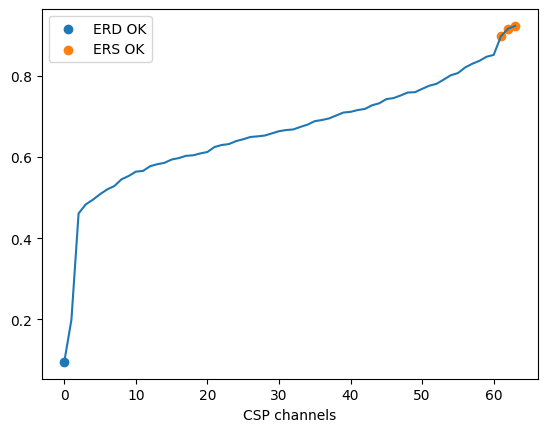

In [34]:
plt.plot(evals)
plt.scatter(ok_evalLow_inds, evals[ok_evalLow_inds],  label='ERD OK')
plt.scatter(ok_evalHigh_inds, evals[ok_evalHigh_inds], label='ERS OK')
plt.xlabel('CSP channels')
plt.legend()

## topoplot

In [35]:
from mne.viz import plot_topomap

In [39]:
filename = r"../resources/mks64_standard.ced"
channels = []
x = []
y = []
theta, radius = [], []
with open(filename, 'r') as file:
    for line in file.readlines()[1:]:
        info = line.split(' ')[0].split('\t')
        channels.append(info[1])
        x.append(float(info[4]))
        y.append(float(info[5]))
        theta.append(float(info[2]))
        radius.append(float(info[3]))

In [40]:
th = np.pi / 180 * np.array(theta)
x = np.round(np.array(radius) * np.cos(th), 2)
y = np.round(np.array(radius) * np.sin(th), 2)

In [41]:
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('jet')
newcmp = ListedColormap(viridisBig(np.linspace(0, 1, 15)))

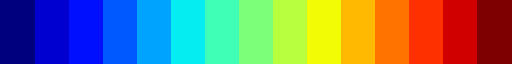

In [42]:
newcmp

<Figure size 1500x400 with 0 Axes>

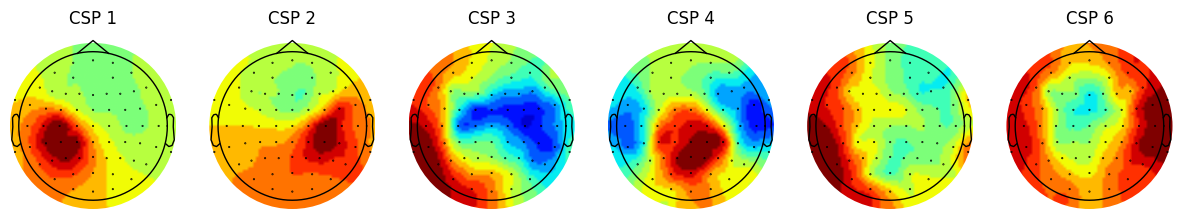

In [43]:
xy = np.concatenate([np.reshape(y, (-1, 1)), np.reshape(x, (-1, 1))], axis=1)
plt.figure(figsize=(15, 4))
n_component = 6
fig, axes = plt.subplots(1, n_component, figsize=(15, 7))
chan_of_inter = np.arange(n_component) #[0, 1, 62, 63] #
for i, ch in enumerate(chan_of_inter):
    plot_topomap(projForward[:, ch], xy, size=5, axes=axes[i], show=False, contours=0, sphere=0.6, cmap=newcmp, extrapolate='head') #, names=channels)
    axes[i].set_title(f'CSP {ch+1}')

<Figure size 1500x400 with 0 Axes>

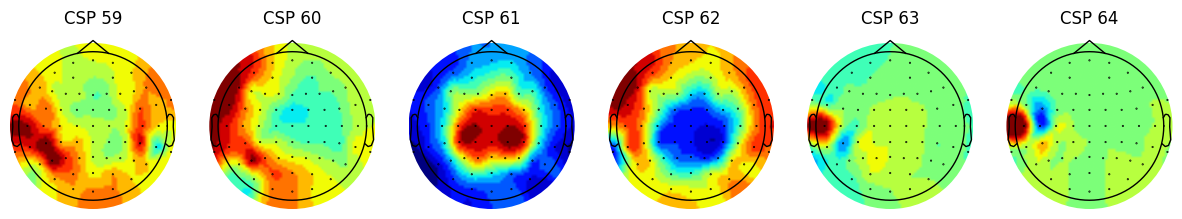

In [44]:
plt.figure(figsize=(15, 4))
n_component = 6
fig, axes = plt.subplots(1, n_component, figsize=(15, 7))
chan_of_inter = np.arange(58, 64, 1) #[0, 1, 62, 63] #
for i, ch in enumerate(chan_of_inter):
    plot_topomap(projForward[:, ch], xy, size=5, axes=axes[i], show=False, contours=0, sphere=0.6, cmap=newcmp, extrapolate='head') #, names=channels)
    axes[i].set_title(f'CSP {ch+1}')

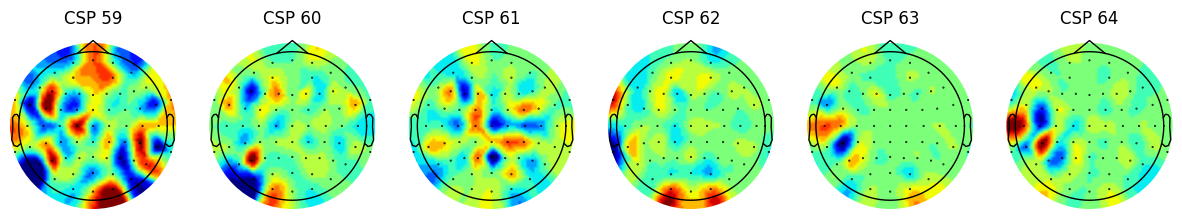

In [45]:
fig, axes = plt.subplots(1, n_component, figsize=(15, 7))
for i, ch in enumerate(chan_of_inter):
    plot_topomap(projInverse[:, ch], xy, size=5, axes=axes[i], show=False,  sphere=0.6, contours = 0, cmap=newcmp, extrapolate='head')  #, names=channels)
    axes[i].set_title(f'CSP {ch+1}')

In [316]:
ch = 63
np.max(projForward[:, ch]), np.min(projForward[:, ch]), np.max(projInverse[:, ch]), np.min(projInverse[:, ch])

(1.240749969513612, -0.284280547351403, 0.754120295110856, -0.3335527422601765)

In [277]:
projForward[:, 62]

array([-0.25199376,  0.08932415,  0.01936192,  0.68239886, -0.01639746,
        0.01331623, -0.55165526,  0.00978556,  0.04744727,  0.43612697,
        0.06944577, -0.01033826,  0.0271795 ,  0.02796002, -0.00985485,
       -0.00542152, -0.04001813, -0.05249169, -0.09247437, -0.0871827 ,
       -0.04260666, -0.03809455, -0.06178087, -0.07724791, -0.01043021,
       -0.02230124,  0.01702631,  0.03538978, -0.02264848, -0.02910817,
        0.00705926,  0.0084626 , -0.02300878, -0.17861716,  0.03934977,
        0.00874899, -0.77137066,  0.15092232,  0.07635542,  0.08189932,
       -0.05124489,  0.02368578,  0.03048737, -0.05092657,  0.01061471,
        0.00589587, -0.00867666,  0.01453824, -0.03176151, -0.02649279,
       -0.05672037, -0.06666043, -0.07113077, -0.09011845, -0.02751546,
       -0.04875466, -0.02921411, -0.08332851, -0.04201091, -0.02583818,
       -0.00795348,  0.00422595,  0.01055143, -0.00658193])

In [389]:
sel_channels = np.arange(6)

## data

In [406]:
def filter(eeg, N=4, lo=6, hi=35, fs=1000):
    # частотный фильтр
    sos = butter(N=N, Wn=(lo, hi), btype='bandpass', output='sos', fs=fs)
    return sosfiltfilt(np.ascontiguousarray(sos), eeg, axis=0)

def get_epochs(eeg, trigger, epoch_width=3000):
    events_ind = np.where(np.diff(trigger) == 1)[0]
    epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind), 1)) 
    epochs = np.array([eeg[x, :64] for x in epochs_ind])
    return epochs

eeg_f1 = eeg_1[:, :64] * (10**6)  #filter(eeg_1[:, :64] * (10**6))
eeg_f2 = eeg_2[:, :64] * (10**6) # filter(eeg_2[:, :64] * (10**6))

epochs_1 = get_epochs(eeg_f1, eeg_1[:, -1], epoch_width=2000)
epochs_2 = get_epochs(eeg_f2, eeg_2[:, -1], epoch_width=2000)

## smart chosing

In [49]:

# eeg_csp_1_cl = (eeg_1[:, :64] * (10**6)) @ projInverse
# eeg_csp_1_p = (eeg_2[:, :64] * (10**6)) @ projInverse
eeg_csp_1 = eeg_f_1 @ projInverse
eeg_csp_2 = eeg_f_2 @ projInverse

# def get_epochs(eeg, trigger, epoch_width=3000):
#     events_ind = np.where(np.diff(trigger) == 1)[0]
#     # epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1001), (len(events_ind), 1)) 
#     epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind), 1)) 
#     epochs = np.array([eeg[x, :64] for x in epochs_ind])
#     return epochs

# # epochs_csp_1 = get_epochs(eeg_csp_1, eeg_1[:, -1], epoch_width=2000)
# epochs_csp_1 = get_epochs(eeg_csp_1, eeg_1_cl[:, -1], epoch_width=2000)
# epochs_csp_2 = get_epochs(eeg_csp_2, eeg_2[:, -1], epoch_width=2000)

In [ ]:
def get_fft(eeg):
    SFT = ShortTimeFFT(win=np.ones(1000), hop=100, fs=1000,  fft_mode='onesided')
    fft_res = np.abs(SFT.stft(eeg, axis=0)) ** 2
    fft_t = SFT.t(len(eeg))
    return fft_res, fft_t

fft_res_1, fft_t_1 = get_fft(eeg_csp_1)
fft_res_2, fft_t_2 = get_fft(eeg_csp_2)

In [52]:
def find_events(trigger): 
    return np.where(np.diff(trigger) == 1)[0]

events_ind_1 = find_events(eeg_1[:, -1])
events_ind_2 = find_events(eeg_2[:, -1])

epoch_width = 2000
epochs_ind_1 = events_ind_1.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_1), 1)) 
epochs_ind_2 = events_ind_2.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_2), 1))

def combine_all_epoch(fft_res, fft_t, epochs_ind):
    ind = (fft_t * 1000).astype(int)
    fft_t_ind = [np.where(np.isin(ind, X))[0] for X in epochs_ind]
    fft_all = []
    for ind in fft_t_ind:
        fft_epoch = fft_res[:41, :, ind].T
        fft_all.extend(fft_epoch)
    fft_all = np.array(fft_all)
    return fft_all

fft_res_all_1 = combine_all_epoch(fft_res_1, fft_t_1, epochs_ind_1)
fft_res_all_2 = combine_all_epoch(fft_res_2, fft_t_2, epochs_ind_2)

In [53]:
np.swapaxes(fft_res_all_1, 1, 2).shape

(2000, 41, 64)

In [ ]:
# filename = r'..\data\test_FFT_res.h5'
# with h5py.File(filename, 'w') as h5f:
#     h5f.create_dataset('mov', data=np.swapaxes(fft_res_all_1, 1, 2))
#     h5f.create_dataset('nomov', data=np.swapaxes(fft_res_all_2, 1, 2))

In [54]:
def histogram_intersection(hist1, hist2):
    
    sign = np.sign(np.nanmedian(hist1) - np.nanmedian(hist2))
    # intersection = np.sum(np.minimum(hist1, hist2))
    # area = 1- (intersection) / (np.sum(hist1) + np.sum(hist2) - intersection) 
    area = np.sum(np.abs( hist1/np.sum(hist1) - hist2 / np.sum(hist2))) / 2
    return sign * area * 100#(100 - intersection / (area/2) * 100)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def calculate_intersections(fft_res_all_1, fft_res_all_2):
    freqs = []
    for ch in range(fft_res_all_1.shape[1]):
        channels = []
        for fr in range(fft_res_all_1.shape[2]):
            # curr_1 = 10 * np.log(normalize(fft_res_all_1[:, ch, fr]))
            # curr_2 = 10 * np.log(normalize(fft_res_all_2[:, ch, fr]))
            # curr_1 = curr_1[np.where(np.isfinite(curr_1))]
            # curr_2 = curr_2[np.where(np.isfinite(curr_2))]
            curr_1 = fft_res_all_1[:, ch, fr]
            curr_2 = fft_res_all_2[:, ch, fr]
            default_bw_1 = stats.median_abs_deviation(curr_1) / 0.6745 * (4/(3*len(curr_1)))**(1/5)
            default_bw_2 = stats.median_abs_deviation(curr_2) / 0.6745 * (4/(3*len(curr_2)))**(1/5)
            min_value = np.min([np.nanmin(curr_1), np.nanmin(curr_2)])
            max_value = np.max([np.nanmax(curr_1), np.nanmax(curr_2)])
            x = np.linspace(min_value, max_value, 100)
            # x1 = np.linspace(np.nanmin(curr_1), np.nanmax(curr_1), 50)
            # x2 = np.linspace(np.nanmin(curr_2), np.nanmax(curr_2), 50)
            x1, x2 = x, x
            estimated_pdf_1 = stats.gaussian_kde(curr_1).evaluate(x1)
            estimated_pdf_2 = stats.gaussian_kde(curr_2).evaluate(x2)
            hist1, hist2 = estimated_pdf_1, estimated_pdf_2
            sign = -1 if np.median(hist1) - np.median(hist2) < 0 else 1
            intersection = sign * 100 * np.sum(np.abs( hist1/np.sum(hist1) - hist2 / np.sum(hist2))) / 2
            # intersection = histogram_intersection(estimated_pdf_1, estimated_pdf_2)
            # hist1, _ = np.histogram(curr_1, bins=100, density=True)
            # hist2, _ = np.histogram(curr_2, bins=100, density=True)
            # intersection = histogram_intersection(hist1, hist2)
            channels.append(intersection)
        freqs.append(channels)
    return np.array(freqs)

In [55]:
fft_res_all_1 = np.concatenate([fft_res_all_1, fft_res_all_2], axis=0)
fft_res_all_1.shape

(3120, 64, 41)

In [56]:
#intersection_matrix - 10 * log
intersection_matrix3 = calculate_intersections(fft_res_all_1, fft_res_all_2)

Text(0.5, 36.72222222222221, 'frequencies')

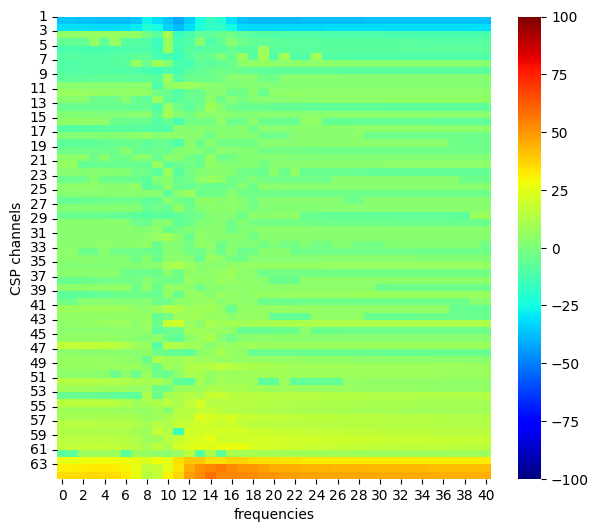

In [57]:
plt.figure(figsize=(7, 6))
# sns.heatmap(intersection_matrix2, vmin=-np.max(intersection_matrix2), vmax=np.max(intersection_matrix2), cmap='Spectral')
sns.heatmap(intersection_matrix3, vmin=-100, vmax=100, cmap='jet')
plt.ylabel('CSP channels')
plt.yticks(np.arange(0, 64, 2), np.arange(1, 65, 2))
plt.xlabel('frequencies')

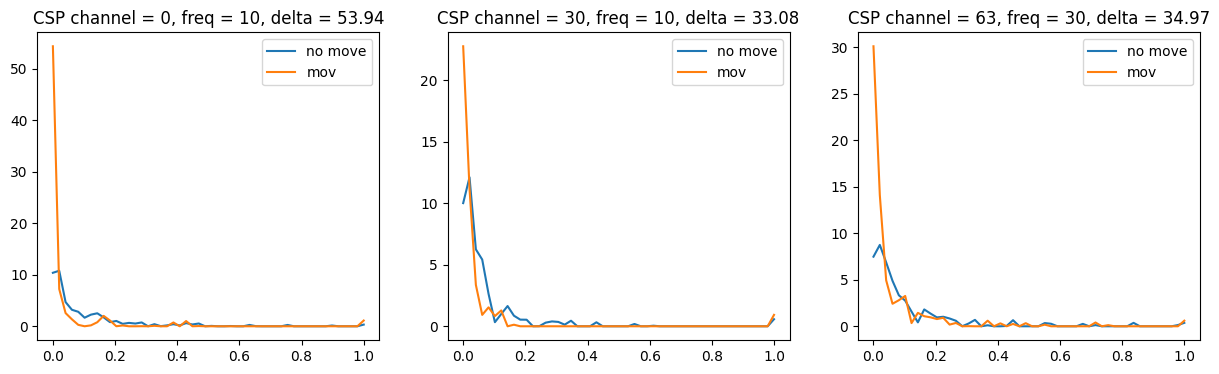

In [59]:
sel = [(0, 10), (30, 10), (63, 30)]

plt.figure(figsize=(15, 4))
for i, pair in enumerate(sel):
    # curr_1 = fft_res_all_1[:, pair[0], pair[1]]
    # curr_2 = fft_res_all_2[:, pair[0], pair[1]]
    curr_1 = normalize(fft_res_all_1[:, pair[0], pair[1]])
    curr_2 = normalize(fft_res_all_2[:, pair[0], pair[1]])
    # curr_1 = 10 * np.log(curr_1)
    # curr_2 = 10 * np.log(curr_2)
    # curr_1 = curr_1[np.where(np.isfinite(curr_1))]
    # curr_2 = curr_2[np.where(np.isfinite(curr_2))]
    default_bw_b = stats.median_abs_deviation(curr_1) / 0.6745 * (4/(3*len(curr_1)))**(1/5)
    default_bw_a = stats.median_abs_deviation(curr_2) / 0.6745 * (4/(3*len(curr_2)))**(1/5)
    min_value = np.min([np.nanmin(curr_1), np.nanmin(curr_2)])
    max_value = np.max([np.nanmax(curr_1), np.nanmax(curr_2)])
    x = np.linspace(min_value, max_value, 50)
    # x = np.arange(-5, 5, 0.01)
    # x = [-np.inf, 0.01, np.inf]
    estimated_pdf_1 = stats.gaussian_kde(curr_1, bw_method=default_bw_b/2).evaluate(x)
    estimated_pdf_2 = stats.gaussian_kde(curr_2, bw_method=default_bw_a/2).evaluate(x)
    # estimated_pdf_1 = stats.gaussian_kde(curr_1).evaluate(x)
    # estimated_pdf_2 = stats.gaussian_kde(curr_2).evaluate(x)
    hist1, hist2 = estimated_pdf_1, estimated_pdf_2
    sign = -1 if np.median(hist1) - np.median(hist2) > 0 else 1
    intersection = sign * 100 * np.sum(np.abs( hist1/np.sum(hist1) - hist2 / np.sum(hist2))) / 2
    # intersection = histogram_intersection(estimated_pdf_1, estimated_pdf_2)
    plt.subplot(1, 3, i+1)
    plt.plot(x, estimated_pdf_2, label='no move')
    plt.plot(x, estimated_pdf_1, label='mov')
    
    # plt.xlim(-0.1, 1.1)
    plt.title(f'CSP channel = {pair[0]}, freq = {pair[1]}, delta = {round(intersection, 2)}')
    plt.legend()
plt.show()

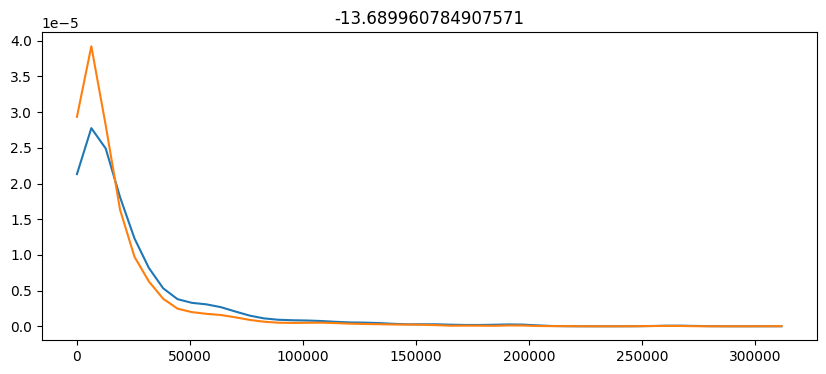

In [60]:
pair = [4, 11]
curr_1 = np.squeeze(fft_res_all_1[:, pair[0], pair[1]])
curr_2 =  np.squeeze(fft_res_all_2[:, pair[0], pair[1]])
# curr_1 = normalize(fft_res_all_1[:, pair[0], pair[1]])
# curr_2 = normalize(fft_res_all_2[:, pair[0], pair[1]])
default_bw_1 = stats.median_abs_deviation(curr_1) / 0.6745 * (4/(3*len(curr_1)))**(1/5)
default_bw_2 = stats.median_abs_deviation(curr_2) / 0.6745 * (4/(3*len(curr_2)))**(1/5)
min_value = np.min([np.nanmin(curr_1), np.nanmin(curr_2)])
max_value = np.max([np.nanmax(curr_1), np.nanmax(curr_2)])
x = np.linspace(min_value, max_value, 50)
# x1 = np.linspace(np.nanmin(curr_1), np.nanmax(curr_1), 50)
# x2 = np.linspace(np.nanmin(curr_2), np.nanmax(curr_2), 50)
x1, x2 = x, x
# estimated_pdf_1 = stats.gaussian_kde(curr_1, bw_method=default_bw_b/2).evaluate(x1)
# estimated_pdf_2 = stats.gaussian_kde(curr_2, bw_method=default_bw_a/2).evaluate(x2)
estimated_pdf_1 = stats.gaussian_kde(curr_1).evaluate(x1)
estimated_pdf_2 = stats.gaussian_kde(curr_2).evaluate(x2)
hist1, hist2 = estimated_pdf_1, estimated_pdf_2
sign = -1 if np.median(hist1) - np.median(hist2) < 0 else 1
intersection = sign * 100 * np.sum(np.abs( hist1/np.sum(hist1) - hist2 / np.sum(hist2))) / 2
plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.hist(curr_1, bins=100)
plt.plot(x2, estimated_pdf_2)
plt.plot(x1, estimated_pdf_1)
# plt.subplot(1, 2, 2)
# plt.hist(curr_2, bins=100)

plt.title(f'{intersection}')
plt.show()

In [61]:
default_bw_1 = stats.median_abs_deviation(curr_1, center=np.mean) / 0.6745 * (4/(3*len(curr_1)))**(1/5)
default_bw_2 = stats.median_abs_deviation(curr_2) / 0.6745 * (4/(3*len(curr_2)))**(1/5)
default_bw_1 /2, default_bw_2/2

(np.float64(1916.6523358860247), np.float64(1664.3961319624636))

In [62]:
fft_res_all_1.shape

(3120, 64, 41)

## spectrogram

In [63]:
import numpy as np

try:
    import cupy as cp
    from cusignal.convolution.convolve import fftconvolve
except:
    cp = np
    from scipy.signal import fftconvolve
    np.asnumpy = np.asarray


def bw_cf(t, bw, cf):
    """Computes the complex wavelet coefficients for the desired time point t,
    bandwidth bw and center frequency cf"""
    cnorm = 1 / (bw * np.sqrt(2 * np.pi))
    exp1 = cnorm * np.exp(-(t ** 2) / (2 * (bw ** 2)));
    res = np.exp(2j * np.pi * cf * t) * exp1
    return res


def gauss(t, sd):
    """Compute the gaussian coefficient for the desired time point t and
    standard deviation sd"""
    cnorm = 1 / (sd * np.sqrt(2 * np.pi))
    res = cnorm * np.exp(-(t ** 2) / (2 * (sd ** 2)))
    return res


def cxmorlet(fc, n_cycles, sfreq):
    """Computes the complex Morlet wavelet for the desired center frequency.
    
    Parameters
    ----------
    fc : center frequency
    n_cycles : number of cycles
    sfreq : sampling frequency
    """
    # we want to have the last peak at 2.5 SD
    sd = (n_cycles / 2) * (1 / fc) / 2.5
    wl = int(2 * np.floor(np.fix(6 * sd * sfreq) / 2) + 1)
    w = np.zeros((wl), dtype=np.complex128)
    gi = 0
    off = np.fix(wl / 2)
    for i in range(wl):
        t = (i - off) / sfreq
        w[i] = bw_cf(t, sd, fc)
        gi += gauss(t, sd)
    w /= gi
    return w


def aslt(data, sfreq, foi, n_cycles, order=None, mult=False):
    """Adaptive superresolution wavelet (superlet) transform.
    
    - data (array_like) : (n_epochs, n_times)
    - sfreq (float) : sampling frequency
    - foi (array_like) : central frequency of interest
    - n_cycles (integer) : number of initial wavelet cycles
    - order (array_like) : interval of super-resolution orders of shape (2,).
      For example, use order=[1, 30]
    - mult (bool) : specifies the use of multiplicative super-resolution (True)
      or additive (False)
    """
    # inputs checking
    assert isinstance(data, np.ndarray)
    data = np.atleast_2d(data).astype(np.float32)
    n_epochs, n_times = data.shape
    foi = np.asarray(foi)
    n_freqs = len(foi)

    # check order parameter and initialize the order used at each frequency. If
    # empty, go with an order of 1 for each frequency (single wavelet per set)
    if order is not None:
        order_ls = np.fix(np.linspace(order[0], order[1], n_freqs)).astype(int)
    else:
        order_ls = np.ones((n_freqs,), dtype=np.int)
        
    # the padding will be size of the lateral zero-pads, which serve to avoid
    # border effects during convolution
    padding = 0
    
    # the wavelet sets
    wavelets = dict()
    
    # initialize wavelet sets for either additive or multiplicative
    # superresolution
    for i_freq in range(n_freqs):
        for i_ord in range(order_ls[i_freq]):
            # get the number of cycles
            if mult:  # multiplicative superresolution
                n_cyc = n_cycles * (i_ord + 1)
            else:     # additive superresolution
                n_cyc = n_cycles + i_ord
            
            # each new wavelet has n_cyc extra cycles
            _w = cxmorlet(foi[i_freq], n_cyc, sfreq)
            
            # the margin will be the half-size of the largest wavelet
            padding = max(padding, np.fix(len(_w) / 2))
            
            wavelets[(i_freq, i_ord)] = _w
    
    # the zero-padded buffer
    buffer = cp.zeros((n_epochs, int(n_times + 2 * padding)),
                      dtype=cp.float32)

    # convenience indexers for the zero-padded buffer
    bufbegin = int(padding)
    bufend = int(padding + n_times)
    
    # fill the central part of the buffer with input data
    buffer[:, bufbegin:bufend] = cp.asarray(data)
    
    # the output scalogram
    wtresult = cp.zeros((n_epochs, n_freqs, n_times), dtype=cp.float32)

    for i_freq in range(n_freqs):
        # pooling buffer, starts with 1 because we're doing geometric mean
        temp = cp.ones((n_epochs, n_times), dtype=cp.float32)

        # compute the convolution of the buffer with each wavelet in the
        # current set
        for i_ord in range(order_ls[i_freq]):
            # get the single wavelets
            sw = cp.asarray(wavelets[(i_freq, i_ord)]).reshape(1, -1)
    
            # restricted convolution (input size == output size)
            _temp = fftconvolve(buffer, sw, mode='same', axes=1)

            # accumulate the magnitude (times 2 to get the full spectral
            # energy
            temp *= (2 * cp.abs(_temp[:, bufbegin:bufend]))

        # compute the power of the geometric mean
        root = 1. / float(order_ls[i_freq])
        temp = (temp ** root) ** 2

        # accumulate the current FOI to the result spectrum
        wtresult[:, i_freq, :] += temp
    
    return cp.asnumpy(wtresult)

c:\Users\ХБ\Documents\projects\analysis_tools\venv\Lib\site-packages\cupy\_environment.py:275: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [64]:
sel_channels = [0, 1, 2, 3, 4, 5]
eeg_csp_1 = eeg_f_1 @ projInverse[:, sel_channels]
eeg_csp_2 = eeg_f_2 @ projInverse[:, sel_channels]

In [66]:
def get_epochs(eeg, trigger, epoch_width=3000):
    events_ind = np.where(np.diff(trigger) == 1)[0]
    # epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1001), (len(events_ind), 1)) 
    epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1001), (len(events_ind), 1)) 
    epochs = np.array([eeg[x, :64] for x in epochs_ind])
    return epochs

# epoch_width = 1000
epochs_csp_1 = get_epochs(eeg_csp_1, eeg_1[:, -1], epoch_width=2000)
epochs_csp_2 = get_epochs(eeg_csp_2, eeg_2[:, -1], epoch_width=2000)

In [67]:
epochs_csp_1[:, :, 0].shape

(100, 3000)

In [68]:
n_comp = 4
fr_needed = np.arange(8, 16)
TFall_1 = aslt(epochs_csp_1[:, :, n_comp], 1000, fr_needed, 5, fr_needed, False)
TFall_2 = aslt(epochs_csp_2[:, :, n_comp], 1000, fr_needed, 5, fr_needed, False)

baseline_1 = np.squeeze(np.nanmedian(TFall_1[:, :, :1000], axis=(0, 2)))
baseline_2 = np.squeeze(np.nanmedian(TFall_2[:, :, :1000], axis=(0, 2)))

TFall_1_mean = np.nanmedian(TFall_1, axis=0)
TFall_2_mean = np.nanmedian(TFall_2, axis=0)

TFall_1_norm = 10 * np.log10(TFall_1_mean.T / baseline_1)
TFall_2_norm = 10 * np.log10(TFall_2_mean.T / baseline_2)

<Figure size 1500x500 with 0 Axes>

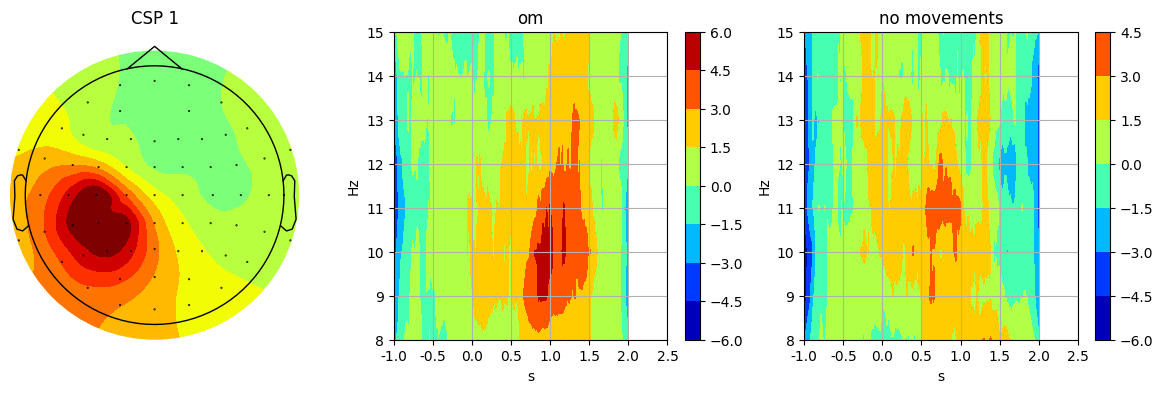

In [71]:
plt.figure(figsize=(15, 5))

n_comp = 0
duration, new_max = 4000, 3
vmax = np.max([np.max(TFall_1_norm), np.max(TFall_2_norm)])
vmin = np.min([np.min(TFall_1_norm), np.min(TFall_2_norm)])
if abs(vmax) > abs(vmin):
    vmin = -vmax
else:
    vmax = -vmin
cmap = 'jet'
fig, axes = plt.subplots(1, 3,  figsize=(15, 4))

plot_topomap(projForward[:, sel_channels[n_comp]], xy, size=3, axes=axes[0], show=False, contours=0, sphere=0.6, cmap=newcmp, extrapolate='head') #, names=channels)
axes[0].set_title(f'CSP {sel_channels[n_comp]+1}')

n_plot = 1
pcm = axes[n_plot].contourf(TFall_1_norm.T, cmap=cmap, vmin=vmin, vmax=vmax)
axes[n_plot].set_yticks(np.arange(0, len(fr_needed), 1), fr_needed)
axes[n_plot].set_xticks(np.arange(0, duration, 500), np.arange(-1, new_max, 0.5))
# axes[n_plot].vlines(1000, 0, 24, color='black', linewidth=2)
# axes[n_plot].vlines(3000, 0, 24, color='black', linewidth=2)
axes[n_plot].set_ylabel('Hz')
axes[n_plot].set_xlabel('s')
axes[n_plot].set_title('om')
axes[n_plot].grid()
fig.colorbar(pcm, ax=axes[n_plot])

n_plot = 2
pcm = axes[n_plot].contourf(TFall_2_norm.T, cmap=cmap, vmin=vmin, vmax=vmax)
axes[n_plot].set_yticks(np.arange(0, len(fr_needed), 1), fr_needed)
axes[n_plot].set_xticks(np.arange(0, duration, 500), np.arange(-1, new_max, 0.5))
# axes[n_plot].vlines(1000, 0, 24, color='black', linewidth=2)
# axes[n_plot].vlines(3000, 0, 24, color='black', linewidth=2)
axes[n_plot].set_ylabel('Hz')
axes[n_plot].set_xlabel('s')
axes[n_plot].set_title('no movements')
axes[n_plot].grid()
fig.colorbar(pcm, ax=axes[n_plot])

In [705]:
eeg_csp_1 = eeg_f1 @ projInverse
eeg_csp_2 = eeg_f2 @ projInverse

## PSD

In [77]:
epochs_csp_1 = get_epochs(eeg_csp_1, eeg_1[:, -1], epoch_width=2000)
epochs_csp_2 = get_epochs(eeg_csp_2, eeg_2[:, -1], epoch_width=2000)

In [ ]:
from matplotlib import mlab

def psd(trials):
    nchannels = 64
    ntrials = trials.shape[0]
    nsamples = 2000
    sample_rate = 1000
    trials_PSD = np.zeros((nchannels, 1001, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[trial, :, ch], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials_PSD.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

In [84]:
psd_om, freqs = psd(epochs_csp_1)
psd_nomove, freqs = psd(epochs_csp_2)
trials_csp_PSD = { 'nomove': psd_nomove, 'om': psd_om}

IndexError: index 6 is out of bounds for axis 2 with size 6

In [75]:
plot_psd(trials_csp_PSD,freqs, [0,28,-1], chan_lab=['first component', 'middle component', 'last component']) # maxy=500)

NameError: name 'trials_csp_PSD' is not defined

## FFT

In [85]:
def get_fft(eeg):
    SFT = ShortTimeFFT(win=np.ones(1000), hop=100, fs=1000,  fft_mode='onesided' )
    fft_res = np.abs(SFT.stft(eeg, axis=0)) ** 2
    fft_t = SFT.t(len(eeg))
    return fft_res, fft_t

fft_res_1, fft_t_1 = get_fft(eeg_csp_1)
fft_res_2, fft_t_2 = get_fft(eeg_csp_2)

In [86]:
def combine_all_epoch(fft_res, fft_t, epochs_ind):
    ind = (fft_t * 1000).astype(int)
    fft_t_ind = [np.where(np.isin(ind, X))[0] for X in epochs_ind]
    fft_all = []
    for ind in fft_t_ind:
        fft_epoch = fft_res[:41, :, ind].T
        fft_all.extend(fft_epoch)
    fft_all = np.array(fft_all)
    return fft_all

def find_events(trigger): 
    return np.where(np.diff(trigger) == 1)[0]

events_ind_1 = find_events(eeg_1[:, -1])
events_ind_2 = find_events(eeg_2[:, -1])

epoch_width = 2000
epochs_ind_1 = events_ind_1.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_1), 1)) 
epochs_ind_2 = events_ind_2.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_2), 1))

fft_res_all_1 = combine_all_epoch(fft_res_1, fft_t_1, epochs_ind_1)
fft_res_all_2 = combine_all_epoch(fft_res_2, fft_t_2, epochs_ind_2)

In [87]:
fft_res_all_1 = combine_all_epoch(fft_res_1, fft_t_1, epochs_ind_1)
fft_res_all_2 = combine_all_epoch(fft_res_2, fft_t_2, epochs_ind_2)

In [88]:
fft_res_all_1.shape

(2000, 6, 41)

In [89]:
sel_channels[1]

1

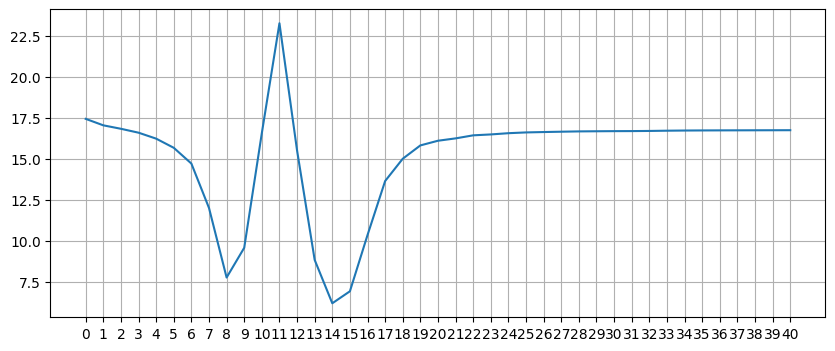

In [90]:
ch = 1#sel_channels[0]
fft_log_1 = np.mean(10 * np.log(fft_res_all_1[:, ch]), axis=0)
fft_log_2 = np.mean(10 * np.log(fft_res_all_2[:, ch]), axis=0)
plt.figure(figsize=(10, 4))
plt.plot(fft_log_2 - fft_log_1)

plt.xticks(np.arange(0, 41))
plt.grid()

In [91]:
diff_ind_f = [10, 11, 12, 21, 22, 23]

feature_1 = np.mean(fft_res_1[diff_ind_f, :, :], axis=0)
feature_2 = np.mean(fft_res_2[diff_ind_f, :, :], axis=0)

In [92]:
def define_features(features, fft_t, epochs_ind):
    ind = (fft_t * 1000).astype(int)
    fft_t_ind = [np.where(np.isin(ind, X))[0] for X in epochs_ind]
    # feature = np.array([np.mean(features[x]) for x in fft_t_ind])
    feature = np.array([np.mean(features[:, x], axis=1) for x in fft_t_ind])
    return feature

feat1 = define_features(feature_1, fft_t_1, epochs_ind_1)
feat2 = define_features(feature_2, fft_t_2, epochs_ind_2)

In [93]:
X = np.concatenate([feat1, feat2], axis=0)
y = np.concatenate([np.ones(len(feat1)), np.zeros(len(feat2))])

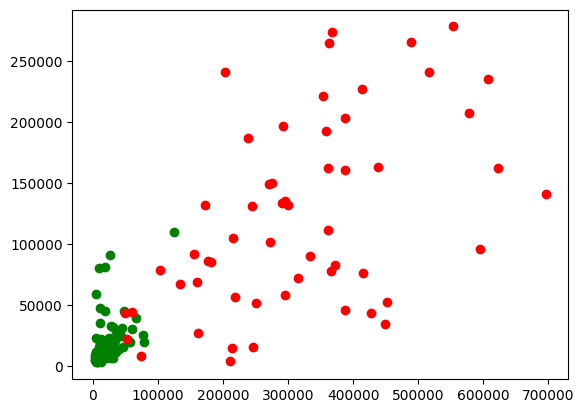

In [94]:
plt.scatter(feat1[:, 0], feat1[:, 1], color='green')
plt.scatter(feat2[:, 0], feat2[:, 1], color='red')

In [95]:
lda = LDA()
scores = cross_validate(lda, X, y, cv=5, scoring=('accuracy', 'balanced_accuracy'), return_train_score=True)
scores

{'fit_time': array([0.00098085, 0.00060463, 0.0005486 , 0.00051641, 0.00051332]),
 'score_time': array([0.00145316, 0.00092864, 0.00087166, 0.00088334, 0.00087786]),
 'test_accuracy': array([0.96875   , 0.90322581, 0.96774194, 0.93548387, 0.83870968]),
 'train_accuracy': array([0.91129032, 0.936     , 0.936     , 0.912     , 0.936     ]),
 'test_balanced_accuracy': array([0.95833333, 0.86363636, 0.95454545, 0.90909091, 0.77272727]),
 'train_balanced_accuracy': array([0.875     , 0.91111111, 0.91111111, 0.87777778, 0.91111111])}